In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
import losses
importlib.reload(losses)
from losses import *
import trainer
importlib.reload(trainer)
from trainer import *
#dtype = torch.float64
dtype = torch.float32
#dtype = torch.double
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

Using device: cuda


In [2]:
import torch

class NBodySimulator:
    def __init__(self, 
                 positions: torch.Tensor,  # shape (N, 3)
                 velocities: torch.Tensor,  # shape (N, 3)
                 masses: torch.Tensor,      # shape (N,)
                 G: float = 1.0,            # gravitational constant
                 softening: float = 1e-3,   # softening length to avoid singularities
                 E_eps: float = 1e-6,  # energy conservation threshold
                 device: torch.device = None):
        """
        N-body simulator using PyTorch.

        Args:
            positions: initial positions (N, 3)
            velocities: initial velocities (N, 3)
            masses:       masses of bodies (N,)
            G:            gravitational constan
            
            softening:    softening parameter ε
            device:       torch.device (cpu or cuda)
        """
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.x = positions.to(self.device)
        self.v = velocities.to(self.device)
        self.m = masses.to(self.device).view(-1, 1)  # (N,1) for broadcasting
        self.G = G
        self.eps = softening
        self.E_eps = E_eps
        self.E = self.total_energy()
        self.P = self.total_momentum()

    def pairwise_forces(self):
        """
        Compute pairwise gravitational forces:
        F_i = G * sum_j m_i*m_j * (x_j - x_i) / (|x_j - x_i|^2 + eps^2)^(3/2)
        Returns:
            forces: Tensor of shape (N, 3)
        """
        # Compute pairwise displacement vectors: (N,1,3) - (1,N,3) -> (N,N,3)
        dx = self.x.unsqueeze(1) - self.x.unsqueeze(0)
        # squared distances with softening
        dist_sqr = (dx**2).sum(dim=2) + self.eps**2  # (N,N)
        dist_sqr_safe = dist_sqr.clamp(min=self.eps)      # never below eps^2
        inv_dist3    = dist_sqr_safe.pow(-1.5)               # (N,N)
        #inv_dist3 = torch.nan_to_num(inv_dist3, nan=0.0, posinf=0.0, neginf=0.0)
        # weight by masses: m_i * m_j
        weight = -self.G * (self.m * self.m.T)       # (N,N)
        # force matrix: weight * inv_dist3 * dx
        F = (weight.unsqueeze(2) * inv_dist3.unsqueeze(2)) * dx  # (N,N,3)
        self.F = F.sum(dim=1)
        # sum over j
        return  self.F

    def step(self, dt: float):
        """
        Advance the system by one time-step dt using velocity-Verlet:
        x(t+dt) = x(t) + v(t)*dt + 0.5*a(t)*dt^2
        compute new a(t+dt), then
        v(t+dt) = v(t) + 0.5*(a(t) + a(t+dt))*dt
        """
        # current acceleration
        a = self.pairwise_forces() / self.m
        # update positions
        self.x = self.x + self.v * dt + 0.5 * a * dt**2
        # compute new acceleration
        a_new = self.pairwise_forces() / self.m
        # update velocities
        self.v = self.v + 0.5 * (a + a_new) * dt

    def run(self, steps: int, dt: float, record: bool = False):
        """
        Run the simulation.

        Args:
            steps: number of steps
            dt:    time-step
            record: if True, return trajectory arrays
        Returns:
            If record=True:
                positions_history: Tensor (steps+1, N, 3)
                velocities_history: Tensor (steps+1, N, 3)
            else: None
        """
        if record:
            xs = [self.x.clone()]
            vs = [self.v.clone()]

        for _ in range(steps):
            self.step(dt)
            if record:
                xs.append(self.x.clone())
                vs.append(self.v.clone())

        if record:
            return torch.stack(xs), torch.stack(vs)

    def kinetic_energy(self):
        # K = 1/2 sum_i m_i v_i^2
        v2 = (self.v**2).sum(dim=1, keepdim=True)           # (N,1)
        return 0.5 * (self.m * v2).sum()

    def potential_energy(self):
        # U = -1/2 G sum_{i!=j} m_i m_j / r_ij
        dx = self.x.unsqueeze(1) - self.x.unsqueeze(0)      # (N,N,3)
        dist = torch.sqrt((dx**2).sum(dim=2) + self.eps**2)  # (N,N)
        dist_safe = dist.clamp(min=self.eps)      # never below eps^2
        mass_prod = self.m * self.m.T                       # (N,N)
        inv_r = 1.0 / dist_safe
        #inv_r = torch.nan_to_num(inv_r, nan=0.0, posinf=0.0, neginf=0.0)
        U = -0.5 * self.G * (mass_prod * inv_r).sum()
        return U

    def total_energy(self):
        return self.kinetic_energy() + self.potential_energy()

    def total_momentum(self):
        # P = sum_i m_i v_i  -> (3,)
        P = (self.m * self.v).sum(dim=0)
        return P


    def run_with_diagnostics(self, steps, dt, record=True):
        """
        Runs the sim and returns histories of energy & momentum.
        """
        if record:
            E_hist = []
            P_hist = []
            # record initial
            E_hist.append(self.total_energy().item())
            P_hist.append(self.total_momentum().cpu().numpy())

            xs = [self.x.clone()]
            vs = [self.v.clone()]

        for _ in range(steps):
            self.step(dt)
            if record:
                E_hist.append(self.total_energy().item())
                P_hist.append(self.total_momentum().cpu().numpy())
                xs.append(self.x.clone())
                vs.append(self.v.clone())

        return torch.stack(xs), torch.stack(vs), torch.tensor(E_hist), torch.tensor(P_hist)  # shapes (steps+1,), (steps+1,3)

    def step_diagnostics(self, dt):
        """
        Perform a single step and return diagnostics.
        """

        # current acceleration
        a = self.F / self.m
        # update positions
        self.x_new = self.x + self.v * dt + 0.5 * a * dt**2
        # compute new acceleration
        a_new = self.F / self.m
        # update velocities
        self.v_new = self.v + 0.5 * (a + a_new) * dt

        E = self.total_energy()
        P = self.total_momentum()
        dE = torch.abs((self.E - E)/self.E)
        if dE > self.E_eps:
            _next = False
        else:
            self.x = self.x_new
            self.v = self.v_new
            self.E = E
            self.P = P
            _next = True
            #dE += torch.abs(self.E_eps/self.E)  # ensure non-zero dE
            dE = dE + torch.abs(self.E_eps / self.E)
            
        return _next, dE






In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_trajectories(positions_hist):
    """
    Static plot of each particle's XY trajectory.
    
    positions_hist: np.ndarray, shape (T, N, 3)
    """
    T, N, _ = positions_hist.shape
    plt.figure()
    for i in range(N):
        xs = positions_hist[:, i, 0]
        ys = positions_hist[:, i, 1]
        plt.scatter(xs[0], ys[0], c="red")
        plt.plot(xs, ys)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Particle Trajectories (XY-plane)')
    plt.show()


def animate_particles(positions_hist, *, interval=50, skip=1, save_path=None):
    """
    Create and display (and optionally save) an animation of the N bodies.
    
    positions_hist: np.ndarray, shape (T, N, 3)
    interval: ms between frames
    skip: show every `skip`-th frame
    save_path: if given (e.g. 'nbody.mp4'), will save the animation to that file
    """
    T, N, _ = positions_hist.shape
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=50)

    # Set plot limits based on full trajectory
    all_x = positions_hist[:, :, 0]
    all_y = positions_hist[:, :, 1]
    ax.set_xlim(all_x.min(), all_x.max())
    ax.set_ylim(all_y.min(), all_y.max())
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('N-body Particle Animation (XY-plane)')

    def init():
        scat.set_offsets([])
        return scat,

    def update(frame_idx):
        frame = frame_idx * skip
        data = positions_hist[frame, :, :2]  # only x,y
        scat.set_offsets(data)
        return scat,

    ani = FuncAnimation(
        fig, update,
        frames=range(0, T//skip),
        init_func=init,
        interval=interval,
        blit=True
    )

    if save_path:
        # Requires ffmpeg installed in your environment
        ani.save(save_path, fps=1000//interval)
        print(f"Animation saved to {save_path}")

    plt.show()


In [ ]:
# Example usage: 3-body problem
N = 3
torch.manual_seed(0)
pos = torch.randn(N, 3) * 1.0
vel = torch.randn(N, 3) * 0.1
mass = torch.rand(N) * 5 + 1  # masses in [1,6)


In [49]:
T = 1.1
steps = 10000
dt = float(T/steps)

sim = NBodySimulator(pos, vel, mass, G=1.0, softening=1e-2)
#positions_hist, _ = sim.run(steps=steps, dt=dt, record=True)
positions_hist, _ , E, P = sim.run_with_diagnostics(steps=steps, dt=dt, record=True)
positions_hist = positions_hist.cpu().numpy()
E = E.cpu().numpy()
P = P.cpu().numpy()

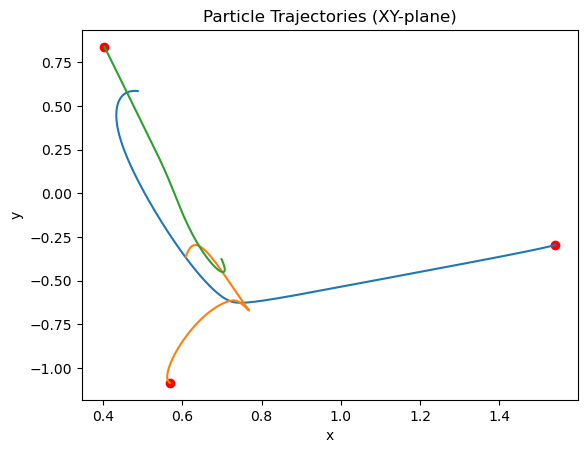

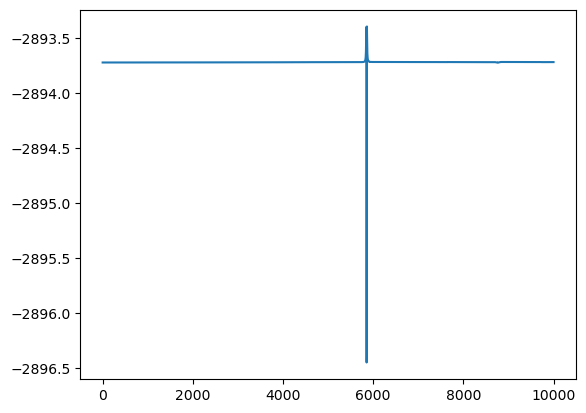

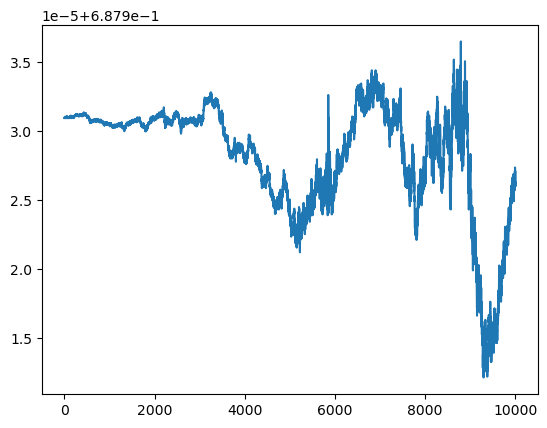

In [52]:
plot_trajectories(positions_hist)
plt.plot(range(steps+1), E)
plt.show()
plt.plot(range(steps+1), np.linalg.norm(P,axis=1))
plt.show()

## Training

In [121]:
torch.autograd.set_detect_anomaly(True)

In [159]:
# --- Build your MLP predictor ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.Sequential(
    nn.Linear(9, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

# --- Online training loop ---
def train_online(epochs=20, 
                N=64,           # particles per sim
                steps_per_epoch=10, 
                E_eps=1e-2,
                device=device
                ):
    loss_history = [] 
    for ep in range(1, epochs+1):
        # 1) Random initial conditions each epoch
        pos  = torch.randn(N, 3, device=device)
        vel  = torch.randn(N, 3, device=device) * 0.1
        mass = torch.rand(N, device=device) * 5 + 1

        sim = NBodySimulator(pos, vel, mass, E_eps=E_eps, device=device)

        running_loss = 0.0
        count        = 0
        _next = True

        # 2) Evolve and train on-the-fly
        for _step in range(steps_per_epoch):

            optimizer.zero_grad()
            while (True):
              if _next:
                # a) compute features & labels
                sim.pairwise_forces() # compute forces to update a_norm
                features = torch.cat([sim.x, sim.v, sim.F], dim=1)  # (N,7)

              dt_pred = torch.abs(model(features))
              #with torch.no_grad():
              _next, dE = sim.step_diagnostics(torch.mean(dt_pred))            # (N,), (N,)

              # b) forward + loss
              if _next:
                loss  =  -torch.sum(dt_pred.squeeze()**2)              
              else:
                loss  =  torch.sum((torch.log(dE)-10)**2) #loss_fn(dt_pred.squeeze(), E)            # scalar
              # c) backward + step optimizer
              #loss.backward()
              loss.backward(retain_graph=True)
              if _next:
                break

            optimizer.step()
            running_loss += loss.item() * N
            count       += N

        avg_loss = running_loss / count
        loss_history.append(avg_loss)   # ← append here
        print(f"Epoch {ep}/{epochs} — Avg MSE: {avg_loss:.6f}")
    return loss_history               # ← return the history
# Run training
loss_hist = train_online(epochs=30, N=3, steps_per_epoch=20)


# Plot the learning curve
plt.figure()
plt.plot(range(1, len(loss_hist)+1), loss_hist, marker='o')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.title('Learning Curve of Timestep Predictor')
plt.grid(True)
plt.tight_layout()
plt.show()

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-py

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [3]:
import torch
import torch.nn as nn

# --- Physics helper functions ---
def pairwise_forces(x: torch.Tensor,
                    m: torch.Tensor,
                    G: float,
                    eps: float) -> torch.Tensor:
    """
    Compute gravitational forces on each of N particles.
    x: (N,3), m: (N,1)
    Returns F: (N,3)
    """
    # (N,1,3) - (1,N,3) -> (N,N,3)
    dx = x.unsqueeze(1) - x.unsqueeze(0)
    # squared distances with softening
    dist2 = (dx*dx).sum(dim=2) + eps*eps   # (N,N)
    # avoid singularity
    inv3  = dist2.clamp(min=eps*eps).pow(-1.5)  # (N,N)
    # mass‐product matrix
    Mmat  = (m * m.T)                         # (N,N)
    # force matrix: G * Mmat * inv3 * dx
    F     = G * Mmat.unsqueeze(-1) * inv3.unsqueeze(-1) * dx  # (N,N,3)
    # sum over j
    return F.sum(dim=1)   # (N,3)

def total_energy(x: torch.Tensor,
                 v: torch.Tensor,
                 m: torch.Tensor,
                 G: float,
                 eps: float) -> torch.Tensor:
    """
    Compute total energy K + U of the system.
    """
    # kinetic
    K = 0.5 * (m * (v*v).sum(dim=1, keepdim=True)).sum()
    # potential
    dx   = x.unsqueeze(1) - x.unsqueeze(0)
    dist = dx.pow(2).sum(dim=2).sqrt().clamp(min=eps)  # (N,N)
    U    = -0.5 * G * ((m*m.T) / dist).sum()
    return K + U

def total_momentum(v: torch.Tensor,
                   m: torch.Tensor) -> torch.Tensor:
    """
    Compute total momentum P = sum_i m_i * v_i.
    """
    return (m * v).sum(dim=0)  # (3,)

# --- One-step functional integrator + diagnostics ---
def step_diagnostics_fn(x: torch.Tensor,
                        v: torch.Tensor,
                        m: torch.Tensor,
                        F: torch.Tensor,
                        E: torch.Tensor,
                        P: torch.Tensor,
                        G: float,
                        eps: float,
                        E_eps: float,
                        dt: torch.Tensor):
    """
    Given state (x,v,E,P), propose one velocity‐Verlet step of size dt,
    compute fractional energy change and acceptance, without mutating inputs.
    Returns: x_new, v_new, E_new, P_new, accept (bool), dE (scalar tensor)
    """
    # 1) current acceleration
    a      = F / m                           # (N,3)

    # 2) propose new positions
    x_new  = x + v * dt + 0.5 * a * dt*dt    # (N,3)

    # 3) propose new velocities
    v_new  = v + a * dt      # (N,3)

    # 5) compute new energy & momentum
    E_new  = total_energy(x_new, v_new, m, G, eps)  # scalar
    P_new  = total_momentum(v_new, m)               # (3,)

    # 6) fractional energy change
    dE     = torch.abs((E - E_new) / E)             # scalar

    # 7) acceptance criterion
    accept = dE <= E_eps

    # 8) bump dE so it's never exactly zero on accept
    dE     = torch.where(
        accept,
        dE + torch.abs(E_eps / E),
        dE
    )

    return x_new, v_new, E_new, P_new, accept, dE

# --- Build the MLP predictor ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = nn.Sequential(
    nn.Linear(7, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

# --- Training loop ---
def train(num_epochs: int = 10,
          N: int = 32,
          max_steps: int = 20,
          G: float = 1.0,
          eps: float = 1e-2,
          E_eps: float = 1e-3):
    loss_history = []

    for epoch in range(1, num_epochs + 1):
        # 1) initialize fresh system
        x  = torch.randn(N, 3, device=device)
        v  = torch.randn(N, 3, device=device) * 0.1
        m  = (torch.rand(N, 1, device=device) * 5.0) + 1.0

        # 2) compute initial diagnostics
        E  = total_energy(x, v, m, G, eps)
        P  = total_momentum(v, m)

        losses = []

        # 3) run up to max_steps
        for _ in range(max_steps):
            # a) compute current acceleration for features
            F   = pairwise_forces(x, m, G, eps)    # (N,3)
            a   = F / m                            # (N,3)
            a_n = torch.norm(a, dim=1, keepdim=True)  # (N,1)

            # b) build features: [x,y,z, vx,vy,vz, |a|]
            features = torch.cat([x, v, a_n], dim=1)   # (N,7)

            # c) predict dt per particle, take mean as step size
            dt_pred = torch.abs(model(features))       # (N,1)
            dt      = dt_pred.mean()                   # scalar

            # d) step forward and get diagnostics
            x, v, E, P, accept, dE = step_diagnostics_fn(
                x, v, m, F, E, P, G, eps, E_eps, dt
            )

            # e) accumulate loss
            if accept:
                # encourage large dt_pred when stable
                losses.append(-(dt_pred**2).sum())
                break
            else:
                # penalize when energy drift gets too large
                losses.append(((torch.log(dE) - 10.0)**2).sum())

        # 4) backward through the entire trajectory
        total_loss = torch.stack(losses).sum()
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())
        print(f"Epoch {epoch}/{num_epochs} — loss = {total_loss.item():.6f}")

    return loss_history

# --- Run training ---
history = train(num_epochs=20, N=64, max_steps=30)
# Optionally, plot history here with matplotlib


KeyboardInterrupt: 

In [2]:
# — physics helpers from before (pairwise_forces, total_energy, total_momentum) —
def pairwise_forces(x,m,G,eps):
    dx    = x.unsqueeze(1) - x.unsqueeze(0)
    dist2 = (dx*dx).sum(-1) + eps*eps
    inv3  = dist2.clamp(min=eps*eps).pow(-1.5)
    F     = -G * (m*m.T).unsqueeze(-1) * inv3.unsqueeze(-1) * dx
    return F.sum(1)

def total_energy(x,v,m,G,eps):
    K = 0.5 * (m*(v*v).sum(1,keepdim=True)).sum()
    dx   = x.unsqueeze(1)-x.unsqueeze(0) + eps
    dist = dx.pow(2).sum(-1).sqrt() #.clamp(min=eps)
    U    = -0.5*G*((m*m.T)/dist).sum()
    return K+U

def total_momentum(v,m):
    return (m*v).sum(0)

def step_diagnostics_fn(x, v, m, F, E, P, G, eps, E_eps, dt):
    # compute accel
    a     = F/m
    # propose step
    x_new = x + v*dt + 0.5*a*dt*dt
    v_new = v +a*dt
    # diagnostics
    E_new = total_energy(x_new, v_new, m, G, eps)
    P_new = total_momentum(v_new, m)
    dE    = torch.abs((E - E_new)/E)
    eps_log = 1e-8
    accept= dE <= E_eps
    return x_new, v_new, E_new, P_new, accept, dE

# — build your MLP —
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.Sequential(
    nn.Linear(7,64), nn.ReLU(),
    nn.Linear(64,64), nn.ReLU(),
    nn.Linear(64,1)
).to(device)

opt   = torch.optim.Adam(model.parameters(), lr=1e-4)

# — per-step online training —
def train_online_per_step(epochs=10, N=64, max_steps=20,
                          G=1.0, eps=1e-2, E_eps=1e-3, max_attempts=100):
    accept = torch.tensor(True)
    for ep in range(1, epochs+1):
        # init state
        x = torch.randn(N,3, device=device)
        v = torch.randn(N,3, device=device)*0.1
        m = (torch.rand(N,1,device=device)*5.0)+1.0
        E = total_energy(x,v,m,G,eps)
        P = total_momentum(v,m)

        step_losses = []
        for step in range(1, max_steps+1):
            print(f"Epoch {ep} step {step} starts")
            # detach state so graph starts clean
            #x = x.detach().clone().requires_grad_(True)
            #v = v.detach().clone().requires_grad_(True)
            #E = E.detach().clone().requires_grad_(True)
            #P = P.detach().clone()

            # build features [x,y,z, vx,vy,vz, |a|]
            #F   = pairwise_forces(x,m,G,eps)
            #F = F.detach()
            #print(F)
            #a   = F/m
            #a_n = torch.norm(a, dim=1, keepdim=True)
            #feats = torch.cat([x, v, a_n], dim=1)
            x_old = x.clone()
            v_old = v.clone()
            E_old = E.clone()
            F = pairwise_forces(x,m,G,eps)
            a   = F/m
            a_n = torch.norm(a, dim=1, keepdim=True)
            a_n_old = a_n.clone()
            attempt = 0
            while attempt < max_attempts:
                x = x_old.detach().clone().requires_grad_(True)
                v = v_old.detach().clone().requires_grad_(True)
                E = E_old.detach().clone()#.requires_grad_(True)
                F = F.detach().clone()#.requires_grad_(True)
                a_n = a_n_old.detach()#.clone().requires_grad_(True)
                m = m.detach().clone()
                #x = x_old.clone()
                #v = v_old.clone()
                #E = E_old.clone()
                # predict dt and step
                #F = F.detach()
                #print(F)

                feats = torch.cat([x, v, a_n], dim=1)
                #print(feats)
                dt_pred = torch.abs(model(feats))      # (N,1)
                #print(dt_pred)
                dt_pred = dt_pred.clamp(min=1e-6, max=1.0)
                dt      = dt_pred.mean()               # scalar
                #print(dt)

                if accept.item() is False:
                    print(dt)
                    print(x,v,E,F,P,a_n,m)
                #    print(accept)
                    #raise

                #x, v, E, P, accept, dE = step_diagnostics_fn(
                x_new, v_new, E_new, P_new, accept, dE = step_diagnostics_fn(
                    x, v, m, F, E, P, G, eps, E_eps, dt
                )

                # define your loss for this step
                if accept:
                    loss = -(dt_pred**2).mean()        # encourage large stable dt
                    #loss = ((torch.log(dE))**2).mean()
                    #safe_dE  = dE.clamp(min=1e-4, max=10.0)
                    #loss = torch.sum((torch.log(dE+1e-4)+4)**2)
                    #print(dE, loss, accept)
                else:
                    #loss = ((torch.log(dE))**2).mean()
                    #loss = (torch.log(dE + eps_log)**2).mean()
                    loss = torch.sum((torch.log(dE+1e-10)-np.log(1e-10))**2)
                    #loss = (dt_pred**2).mean()        # encourage large stable dt
                    print(dE, loss, accept)
                    if torch.isnan(loss):
                        raise

                # backward & optimize for this single step
                opt.zero_grad()
                #loss.backward(retain_graph=True)  # retain graph for next step
                loss.backward()  # retain graph for next step
                opt.step()

                # 3) After your optimizer.step(), check the weights
                for name, param in model.named_parameters():
                    if torch.isnan(param).any() or torch.isinf(param).any():
                        print(f"⚠️  NaN/Inf in weights at {name}")
                        # as a drastic measure, zero out bad grads or reset weights
                        param.data = torch.nan_to_num(param.data, nan=0.0, posinf=1.0, neginf=-1.0)

                if accept:
                    print(f"Epoch {ep} step {step}: accepted, loss={loss.item():.4e}")
                    break
                else:
                    print(f"Epoch {ep} step {step}: rejected, loss={loss.item():.4e}")
                    attempt += 1

            x, v, E, P = x_new, v_new, E_new, P_new
            step_losses.append(loss.item())

        avg_loss = sum(step_losses)/len(step_losses)
        print(f"→ Epoch {ep} done, avg per-step loss = {avg_loss:.4e}\n")

if __name__=="__main__":
    train_online_per_step(epochs=10, N=3, max_steps=20,
                            G=1.0, eps=1e-5, E_eps=1e-3)


Epoch 1 step 1 starts
Epoch 1 step 1: accepted, loss=-1.1058e-03
Epoch 1 step 2 starts
Epoch 1 step 2: accepted, loss=-1.2323e-03
Epoch 1 step 3 starts
Epoch 1 step 3: accepted, loss=-1.3724e-03
Epoch 1 step 4 starts
Epoch 1 step 4: accepted, loss=-1.5139e-03
Epoch 1 step 5 starts
Epoch 1 step 5: accepted, loss=-1.6586e-03
Epoch 1 step 6 starts
Epoch 1 step 6: accepted, loss=-1.8207e-03
Epoch 1 step 7 starts
Epoch 1 step 7: accepted, loss=-2.0007e-03
Epoch 1 step 8 starts
Epoch 1 step 8: accepted, loss=-2.1968e-03
Epoch 1 step 9 starts
Epoch 1 step 9: accepted, loss=-2.3850e-03
Epoch 1 step 10 starts
Epoch 1 step 10: accepted, loss=-2.5787e-03
Epoch 1 step 11 starts
Epoch 1 step 11: accepted, loss=-2.7751e-03
Epoch 1 step 12 starts
Epoch 1 step 12: accepted, loss=-2.9589e-03
Epoch 1 step 13 starts
Epoch 1 step 13: accepted, loss=-3.1116e-03
Epoch 1 step 14 starts
Epoch 1 step 14: accepted, loss=-3.2233e-03
Epoch 1 step 15 starts
Epoch 1 step 15: accepted, loss=-3.3260e-03
Epoch 1 step 